In [1]:
import json
# We omit warnings to keep the output clean
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt 
import nltk

from common_utils import load_glove_embeddings, set_seed, EmbeddingMatrix

In [2]:
# set seed 
set_seed()

# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 
EMBEDDING_DIM=100
GRADIENT_CLIP=5

In [3]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

In [4]:
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()

print("The index of <PAD> is: ", word_embeddings.pad_idx)

print(word_embeddings.to_tensor[word_embeddings.pad_idx])

The index of <PAD> is:  18030
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# create train, validate and test datasets and dataloaders
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EmbeddingsDataset(Dataset):
    def __init__(self, X, y, word_embeddings:EmbeddingMatrix =word_embeddings, sort = False):
        self.word_embeddings = word_embeddings
        tokenized_sentences = []
        for sentence in X:
            tokens = self.tokenize_sentence(sentence)
            tokenized_sentences.append(tokens)

        # Combine tokens, labels, and lengths into a list of tuples
        data = list(zip(tokenized_sentences, y))
        # Sort the data based on the length of the tokenized sentences
        if sort:
            data.sort(key=lambda x: len(x[0]), reverse=False)  # Set reverse=True for descending order

        # Unzip the sorted data back into tokens and labels
        self.tokens_list, self.labels_list = zip(*data)
        self.len = len(self.tokens_list)

    def __getitem__(self, index):
        # tokenize the sentence
        return self.tokens_list[index], self.labels_list[index]

    def __len__(self):
        return self.len 

    def tokenize_sentence(self, x): 
        '''
    returns a list containing the embeddings of each token 
    '''
        tokens = nltk.word_tokenize(x)
        # word tokens to index, skip if token is not in the word embeddings
        tokens = [self.word_embeddings.get_idx(token) for token in tokens if self.word_embeddings.get_idx(token) is not None]
        return tokens


def pad_collate(batch, pad_value):
    (xx, yy) = zip(*batch)
    # convert xx to a tensor
    xx = [torch.tensor(x, dtype=torch.int64) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.tensor(yy, dtype=torch.long)

In [6]:
train_dataset_ed_sorted = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"],
    sort=True
)
validation_dataset_ed_sorted = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"],
    sort=True
)
test_dataset_ed_sorted = EmbeddingsDataset(test_dataset["text"], test_dataset["label"], sort=True)

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader_sorted = DataLoader(
    train_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader_sorted = DataLoader(
    validation_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader_sorted = DataLoader(
    test_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

In [7]:
# using nn.Embeddings 
class VanillaRNNWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,  embedding_matrix_torch:torch.tensor, padding_idx: int, drop_out=0.3):
        super(VanillaRNNWithEmbedding, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.drop_out = nn.Dropout(drop_out)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        res, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = self.drop_out(res)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res


In [8]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [9]:
def train_loop_bce(train_dataloader, model, loss_fn, optimizer):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        # Forward pass
        pred = model(X_batch)
        
        pred = pred.squeeze(1)
        pred_binary = (pred >= 0.5).long()
        loss = loss_fn(pred, y_batch.float())
        train_loss += loss.item() 
        train_correct += (pred_binary==y_batch.long()).sum().item() 
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # TODO add main branch
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop_bce(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch.long()).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [10]:
def train(model, optim, criterion, training_dataloader, validation_dataloader, epoch = NUM_EPOCHS):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  for i in range(epoch):
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim) 
    validate_loss, validate_correct = test_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
  return train_acc, validation_acc, train_losses, validate_losses

In [11]:
vanilla_rnn = VanillaRNNWithEmbedding(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train(vanilla_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, epoch=100)

Epoch 1, Train Loss: 0.6928, Validate Loss: 0.6787
Epoch:1 	 Train Acc:0.5182883939038687 	 Validation Acc:0.6228893058161351
Epoch 2, Train Loss: 0.6664, Validate Loss: 0.6341
Epoch:2 	 Train Acc:0.6209847596717468 	 Validation Acc:0.6735459662288931
Epoch 3, Train Loss: 0.6216, Validate Loss: 0.5896
Epoch:3 	 Train Acc:0.661430246189918 	 Validation Acc:0.7035647279549718
Epoch 4, Train Loss: 0.5897, Validate Loss: 0.5677
Epoch:4 	 Train Acc:0.6854630715123095 	 Validation Acc:0.725140712945591
Epoch 5, Train Loss: 0.5738, Validate Loss: 0.5535
Epoch:5 	 Train Acc:0.6984759671746776 	 Validation Acc:0.7363977485928705
Epoch 6, Train Loss: 0.5621, Validate Loss: 0.5431
Epoch:6 	 Train Acc:0.7101992966002345 	 Validation Acc:0.7467166979362101
Epoch 7, Train Loss: 0.5524, Validate Loss: 0.5342
Epoch:7 	 Train Acc:0.7128956623681125 	 Validation Acc:0.7504690431519699
Epoch 8, Train Loss: 0.5453, Validate Loss: 0.5268
Epoch:8 	 Train Acc:0.7205158264947245 	 Validation Acc:0.75609756097

In [14]:
def plot(a: dict, x_label = "", y_label = "", title = ""):
    for key in a:
        plt.plot(a[key], label=key)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

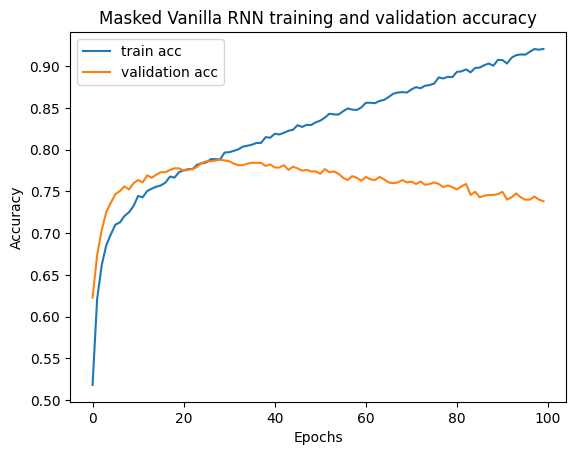

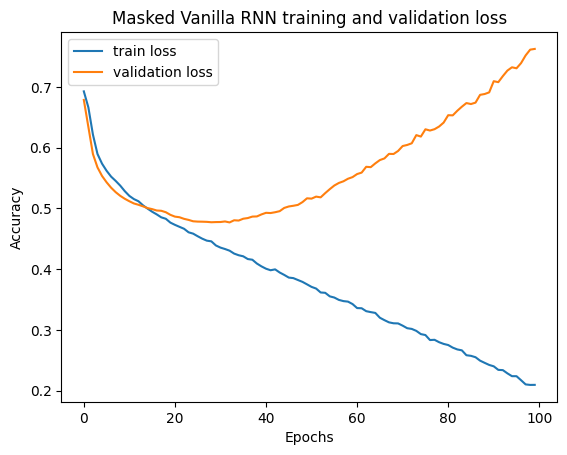

best performance with validation acc: 0.7879924953095685 validation loss: 0.47736173912006263


In [15]:
plot({"train acc": train_acc_vanilla_rnn, "validation acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN training and validation accuracy")
plot({"train loss": train_loss_vanilla_rnn, "validation loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN training and validation loss")

i = validation_acc_vanilla_rnn.index(max(validation_acc_vanilla_rnn))
print("best performance with validation acc:", max(validation_acc_vanilla_rnn), "validation loss:", validation_loss_vanilla_rnn[i])